In [1]:
# ========================================================================
# 1: Install Dependencies
# ========================================================================
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers>=4.37.0
!pip install -q datasets
!pip install -q pandas numpy matplotlib seaborn
!pip install -q openai
!pip install -q sentencepiece
!pip install -q protobuf

print("All dependencies installed successfully!")

All dependencies installed successfully!


In [2]:
# ========================================================================
# 2: Import Libraries and Check GPU
# ========================================================================
import json
import csv
import random
import os
import re
from pathlib import Path
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Check GPU
print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected! Evaluation will be slower.")

Libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [3]:
# ========================================================================
# CELL 3: Configuration
# ========================================================================
class Config:
    # Model configuration
    BASE_MODEL = "Qwen/Qwen2.5-3B-Instruct"
    HF_TOKEN = ""

    # Paths (Colab-specific)
    WORK_DIR = "/content/qwen_base_evaluation"
    TEST_FILE = f"{WORK_DIR}/test.jsonl"
    RESULTS_DIR = f"{WORK_DIR}/evaluation_results"

    # Evaluation parameters
    CTX_LEN = 2048

    # Generation parameters for base model
    GEN_KWARGS = {
        "max_new_tokens": 200,
        "temperature": 0.9,
        "top_p": 0.9,
        "top_k": 40,
        "repetition_penalty": 1.05,
        "no_repeat_ngram_size": 3,
        "do_sample": True
    }

    # Self-evaluation parameters
    SELF_EVAL_GEN_KWARGS = {
        "max_new_tokens": 96,
        "temperature": 0.7,
        "top_p": 0.9,
        "top_k": 40,
        "repetition_penalty": 1.05,
        "do_sample": False
    }

    # LLM Judge Configuration
    OPENAI_REDACTED
    JUDGE_MODEL = "gpt-4o-mini"
    JUDGE_RUBRIC = "helpfulness and correctness"
    JUDGE_SCORE_RANGE = "1 to 5"

# Create directories
os.makedirs(Config.WORK_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

print("Configuration loaded!")
print(f"Working directory: {Config.WORK_DIR}")
print(f"Base model: {Config.BASE_MODEL}")
print(f"Results will be saved to: {Config.RESULTS_DIR}")

Configuration loaded!
Working directory: /content/qwen_base_evaluation
Base model: Qwen/Qwen2.5-3B-Instruct
Results will be saved to: /content/qwen_base_evaluation/evaluation_results


In [5]:
# ========================================================================
# 4: Upload Test Data
# ========================================================================
from google.colab import files

print("Please upload test.jsonl file...")
print("Expected format: JSONL with 'messages' field (same format as training)")
print("-" * 70)

uploaded = files.upload()

if uploaded:
    jsonl_filename = list(uploaded.keys())[0]
    print(f"\nFile '{jsonl_filename}' uploaded successfully!")

    # Save to working directory
    import shutil
    shutil.move(jsonl_filename, Config.TEST_FILE)
    print(f"Saved to: {Config.TEST_FILE}")

    # Verify the file
    test_df = pd.read_json(Config.TEST_FILE, lines=True)
    print(f"\nTest data loaded: {len(test_df)} samples")
    print(f"Columns: {list(test_df.columns)}")
else:
    print(" No file uploaded!")

Please upload test.jsonl file...
Expected format: JSONL with 'messages' field (same format as training)
----------------------------------------------------------------------


Saving test.jsonl to test.jsonl

File 'test.jsonl' uploaded successfully!
Saved to: /content/qwen_base_evaluation/test.jsonl

Test data loaded: 147 samples
Columns: ['messages']


In [6]:
# ========================================================================
# 5: Load Base Model (Without Fine-Tuning)
# ========================================================================
def load_base_model():
    """Load the base Qwen model without any fine-tuning"""
    print("\nLoading base Qwen model (without fine-tuning)...")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        Config.BASE_MODEL,
        trust_remote_code=True,
        use_fast=True
    )

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    tokenizer.model_max_length = Config.CTX_LEN

    print("Tokenizer loaded")

    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        Config.BASE_MODEL,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.float16,
    )

    model.eval()

    print(f"Base model loaded ({model.num_parameters() / 1e9:.2f}B parameters)")
    print("NOTE: This is the BASE model WITHOUT fine-tuning")

    return model, tokenizer

# Load the base model
base_model, base_tokenizer = load_base_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model ready on {device}")


Loading base Qwen model (without fine-tuning)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizer loaded


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Base model loaded (3.09B parameters)
NOTE: This is the BASE model WITHOUT fine-tuning
Model ready on cuda


In [7]:
# ========================================================================
# 6: Helper Functions for Generation
# ========================================================================
def generate_feedback(
    model,
    tokenizer,
    device,
    question: str,
    answer: str,
    domain: str = None,
    **gen_kwargs
) -> str:
    """Generate feedback for a given question-answer pair"""
    system_msg = f"You are a rigorous {domain} interviewer." if domain else "You are a rigorous interviewer."
    system_msg += " Evaluate answers and provide constructive feedback with follow-up questions."

    messages = [
        {"role": "system", "content": system_msg},
        {"role": "assistant", "content": question},
        {"role": "user", "content": answer},
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=Config.CTX_LEN
    ).to(device)

    generation_config = {**Config.GEN_KWARGS, **gen_kwargs}

    with torch.no_grad():
        output = model.generate(
            **inputs,
            **generation_config,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_ids = output[0][inputs["input_ids"].shape[1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return generated_text.strip()

def parse_feedback_and_followup(text: str) -> Tuple[str, str]:
    """Split generated text into feedback and follow-up question"""
    marker = re.compile(r'(?:\r?\n)?Follow[- ]?up[:\s]*', re.IGNORECASE)
    match = marker.search(text)

    if match:
        feedback = text[:match.start()].strip()
        followup = text[match.end():].strip()
    else:
        feedback = text.strip()
        followup = ""

    return feedback, followup

print("Helper functions loaded!")

Helper functions loaded!


In [8]:
# ========================================================================
# CELL 7: Prepare Test Data
# ========================================================================
def prepare_test_data(test_file: str) -> pd.DataFrame:
    """Load and parse test data from JSONL file"""
    print("\nPreparing test data...")

    test_df = pd.read_json(test_file, lines=True)

    def parse_messages(row):
        messages = row['messages']
        question = messages[1]['content']
        answer = messages[2]['content']
        reference = messages[3]['content']

        # Extract domain from system message
        domain_match = re.search(r'rigorous (\w+(?:\s+\w+)*) interviewer', messages[0]['content'])
        domain = domain_match.group(1) if domain_match else 'technical'

        return pd.Series({
            'question': question,
            'answer': answer,
            'reference_feedback': reference,
            'domain': domain
        })

    test_df = pd.concat([test_df, test_df.apply(parse_messages, axis=1)], axis=1)

    print(f"Test data prepared: {len(test_df)} samples")
    print(f"Domains: {test_df['domain'].value_counts().to_dict()}")

    return test_df

# Load test data
test_df = prepare_test_data(Config.TEST_FILE)


Preparing test data...
Test data prepared: 147 samples
Domains: {'Data Science': 43, 'Python codeing': 32, 'Behavioral': 21, 'SQL': 15, 'NoSQL': 11, 'Excel': 9, 'Machine Learning': 7, 'Statistics': 5, 'Python': 3, 'Deep Learning': 1}


In [9]:
# ========================================================================
# 8: Generate Predictions for All Test Samples
# ========================================================================
print("\n Generating predictions for all test samples...")
print("This may take 30-60 minutes depending on test set size...")
print("=" * 70)

predictions = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating feedback"):
    pred = generate_feedback(
        model=base_model,
        tokenizer=base_tokenizer,
        device=device,
        question=row['question'],
        answer=row['answer'],
        domain=row['domain']
    )
    predictions.append(pred)

test_df['predicted_feedback'] = predictions

# Save intermediate results
predictions_file = f"{Config.RESULTS_DIR}/base_model_predictions.csv"
test_df.to_csv(predictions_file, index=False)
print(f"\n Predictions saved to: {predictions_file}")
print(f"Average feedback length: {test_df['predicted_feedback'].str.len().mean():.0f} characters")


 Generating predictions for all test samples...
This may take 30-60 minutes depending on test set size...


Generating feedback: 100%|██████████| 147/147 [29:26<00:00, 12.02s/it]


 Predictions saved to: /content/qwen_base_evaluation/evaluation_results/base_model_predictions.csv
Average feedback length: 952 characters


In [10]:
# ========================================================================
# 9: EVALUATION METRIC 1 - Perplexity (PPL)
# ========================================================================
def compute_perplexity(model, tokenizer, texts: List[str], device) -> float:
    """
    Compute average perplexity on a set of texts.
    Lower perplexity = better model performance
    """
    print("\n Computing Perplexity...")
    model.eval()

    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for text in tqdm(texts, desc="Computing perplexity"):
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=Config.CTX_LEN
            ).to(device)

            outputs = model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item() * inputs["input_ids"].size(1)
            total_tokens += inputs["input_ids"].size(1)

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    print(f"Perplexity: {perplexity:.3f}")

    return perplexity

# Prepare texts for perplexity calculation
perplexity_texts = test_df['predicted_feedback'].tolist()

# Calculate perplexity
base_perplexity = compute_perplexity(base_model, base_tokenizer, perplexity_texts, device)

# Save result
perplexity_results = {
    "model": "Qwen Base (No Fine-tuning)",
    "perplexity": base_perplexity,
    "num_samples": len(perplexity_texts)
}

with open(f"{Config.RESULTS_DIR}/perplexity_results.json", 'w') as f:
    json.dump(perplexity_results, f, indent=2)

print(f"\n PERPLEXITY RESULT: {base_perplexity:.3f}")


 Computing Perplexity...


Computing perplexity: 100%|██████████| 147/147 [00:14<00:00,  9.91it/s]

Perplexity: 4.283

 PERPLEXITY RESULT: 4.283


In [11]:
# ========================================================================
# 10: EVALUATION METRIC 2 - Self-Assessment
# ========================================================================
def self_evaluate_response(
    model,
    tokenizer,
    device,
    question: str,
    user_answer: str,
    model_feedback: str
) -> Dict:
    """
    Use the model to evaluate its own response.
    Returns confidence (1-5) and reason - CHANGED TO 1-5 SCALE
    """
    # Create self-evaluation prompt (1-5 scale to match fine-tuned results)
    self_eval_prompt = f"""you are assessing your own answer. provide:
- confidence: number 1..5 indicating how correct and complete your answer is
- reason: one short sentence
return valid json: {{"confidence": <1..5>, "reason": "<...>"}}

question: {question}
your answer: {model_feedback}

json:"""

    # Format as chat message
    messages = [
        {
            "role": "system",
            "content": "You are evaluating the quality of interview feedback."
        },
        {
            "role": "user",
            "content": self_eval_prompt
        }
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=Config.CTX_LEN
    ).to(device)

    # Generate self-evaluation
    with torch.no_grad():
        output = model.generate(
            **inputs,
            **Config.SELF_EVAL_GEN_KWARGS,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_ids = output[0][inputs["input_ids"].shape[1]:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    # Parse JSON response
    try:
        # Try to extract JSON from response
        json_match = re.search(r'\{[^}]+\}', response)
        if json_match:
            result = json.loads(json_match.group())
            confidence = float(result.get('confidence', 3))
            reason = result.get('reason', 'No reason provided')
        else:
            # Fallback: try to extract confidence number
            conf_match = re.search(r'confidence["\s:]+(\d+)', response, re.IGNORECASE)
            confidence = float(conf_match.group(1)) if conf_match else 3.0
            reason = response[:100]  # Use first 100 chars as reason
    except:
        # Default fallback
        confidence = 3.0
        reason = "Failed to parse self-evaluation"

    # Normalize confidence to 1-5 range
    confidence = max(1.0, min(5.0, confidence))

    return {
        "self_conf_1_5": confidence,
        "self_conf_reason": reason,
        "raw_response": response
    }

def run_self_evaluation(model, tokenizer, device, test_df: pd.DataFrame) -> pd.DataFrame:
    """Run self-evaluation on all test samples"""
    print("\n Running Self-Assessment by Base Model...")
    print("=" * 70)

    self_eval_results = []

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Self-evaluating"):
        # Get model's feedback
        model_feedback = row['predicted_feedback']

        # Get self-evaluation
        self_eval = self_evaluate_response(
            model=model,
            tokenizer=tokenizer,
            device=device,
            question=row['question'],
            user_answer=row['answer'],
            model_feedback=model_feedback
        )

        self_eval_results.append(self_eval)

    # Add results to dataframe
    test_df['self_conf_1_5'] = [r['self_conf_1_5'] for r in self_eval_results]
    test_df['self_conf_reason'] = [r['self_conf_reason'] for r in self_eval_results]

    # Calculate statistics
    avg_confidence = test_df['self_conf_1_5'].mean()
    std_confidence = test_df['self_conf_1_5'].std()

    print("\n Self-Assessment Results:")
    print(f"   Average Confidence: {avg_confidence:.3f} / 5")
    print(f"   Std Deviation: {std_confidence:.3f}")
    print(f"   Min Confidence: {test_df['self_conf_1_5'].min():.2f}")
    print(f"   Max Confidence: {test_df['self_conf_1_5'].max():.2f}")

    # Save detailed results
    self_eval_file = f"{Config.RESULTS_DIR}/self_evaluation_scores.csv"
    test_df[['domain', 'question', 'answer', 'predicted_feedback',
             'self_conf_1_5', 'self_conf_reason']].to_csv(
        self_eval_file,
        index=False
    )

    print(f"\n Self-evaluation scores saved to: {self_eval_file}")

    return test_df

# Run self-evaluation
test_df = run_self_evaluation(base_model, base_tokenizer, device, test_df)


 Running Self-Assessment by Base Model...


Self-evaluating: 100%|██████████| 147/147 [05:18<00:00,  2.17s/it]


 Self-Assessment Results:
   Average Confidence: 3.633 / 5
   Std Deviation: 0.653
   Min Confidence: 2.00
   Max Confidence: 5.00

 Self-evaluation scores saved to: /content/qwen_base_evaluation/evaluation_results/self_evaluation_scores.csv


In [12]:
# ========================================================================
# 11: EVALUATION METRIC 3 - Human Evaluation Framework
# ========================================================================
class HumanEvaluationFramework:
    """
    Human Evaluation Framework with Final Score (1-5)
    """
    CRITERIA = {
        "relevance": {
            "description": "How relevant is the feedback to the candidate's answer?",
            "scale": "1 (Not relevant) to 5 (Highly relevant)"
        },
        "constructiveness": {
            "description": "How constructive and actionable is the feedback?",
            "scale": "1 (Not constructive) to 5 (Very constructive)"
        },
        "accuracy": {
            "description": "Is the feedback technically accurate and appropriate?",
            "scale": "1 (Inaccurate) to 5 (Completely accurate)"
        },
        "specificity": {
            "description": "Does the feedback provide specific examples or guidance?",
            "scale": "1 (Very generic) to 5 (Very specific)"
        },
        "followup_quality": {
            "description": "Is the follow-up question relevant and well-crafted?",
            "scale": "1 (Poor) to 5 (Excellent)"
        },
        "tone": {
            "description": "Is the tone professional and encouraging?",
            "scale": "1 (Inappropriate) to 5 (Excellent)"
        },
        "final_score": {
            "description": "Overall quality of the feedback (considering all criteria)",
            "scale": "1 (Poor) to 5 (Excellent)"
        }
    }

    @staticmethod
    def generate_evaluation_template(samples: List[Dict]) -> pd.DataFrame:
        """Generate a template CSV for human evaluators"""
        eval_data = []

        for idx, sample in enumerate(samples):
            feedback, followup = parse_feedback_and_followup(sample.get('predicted_feedback', ''))

            row = {
                'sample_id': idx + 1,
                'domain': sample.get('domain', ''),
                'question': sample.get('question', ''),
                'answer': sample.get('answer', ''),
                'model_feedback': feedback,
                'model_followup': followup,
                'relevance_score': '',
                'constructiveness_score': '',
                'accuracy_score': '',
                'specificity_score': '',
                'followup_quality_score': '',
                'tone_score': '',
                'final_score': '',  # Overall score 1-5
                'comments': ''
            }
            eval_data.append(row)

        return pd.DataFrame(eval_data)

def generate_human_eval_template(test_df: pd.DataFrame, n_samples: int = 50):
    """Generate human evaluation template"""
    print("\n Generating Human Evaluation Template...")

    # Select random samples
    n_samples = min(n_samples, len(test_df))
    human_eval_samples = test_df.sample(n=n_samples, random_state=42)

    samples_for_eval = human_eval_samples[
        ['domain', 'question', 'answer', 'predicted_feedback']
    ].to_dict('records')

    framework = HumanEvaluationFramework()
    eval_template = framework.generate_evaluation_template(samples_for_eval)

    template_file = f"{Config.RESULTS_DIR}/human_evaluation_template.csv"
    eval_template.to_csv(template_file, index=False)

    print(f" Human evaluation template generated: {template_file}")
    print(f"   Samples selected: {n_samples}")

    print("\n Instructions for human evaluators:")
    print("   1. Open the CSV file in Excel or Google Sheets")
    print("   2. For each sample, rate on a scale of 1-5 for each criterion")
    print("   3. Provide a FINAL_SCORE (1-5) for overall feedback quality")
    print("   4. Add any comments in the 'comments' column")
    print("   5. Save the completed file for analysis")

    print("\n Evaluation Criteria:")
    for criterion, details in framework.CRITERIA.items():
        print(f"   • {criterion.upper()}: {details['scale']}")

    return template_file

# Generate template
human_eval_template = generate_human_eval_template(test_df, n_samples=50)


 Generating Human Evaluation Template...
 Human evaluation template generated: /content/qwen_base_evaluation/evaluation_results/human_evaluation_template.csv
   Samples selected: 50

 Instructions for human evaluators:
   1. Open the CSV file in Excel or Google Sheets
   2. For each sample, rate on a scale of 1-5 for each criterion
   3. Provide a FINAL_SCORE (1-5) for overall feedback quality
   4. Add any comments in the 'comments' column
   5. Save the completed file for analysis

 Evaluation Criteria:
   • RELEVANCE: 1 (Not relevant) to 5 (Highly relevant)
   • CONSTRUCTIVENESS: 1 (Not constructive) to 5 (Very constructive)
   • ACCURACY: 1 (Inaccurate) to 5 (Completely accurate)
   • SPECIFICITY: 1 (Very generic) to 5 (Very specific)
   • FOLLOWUP_QUALITY: 1 (Poor) to 5 (Excellent)
   • TONE: 1 (Inappropriate) to 5 (Excellent)
   • FINAL_SCORE: 1 (Poor) to 5 (Excellent)


In [13]:
# ========================================================================
# 12: EVALUATION METRIC 4 - LLM as Judge (GPT-4o-mini)
# ========================================================================
from openai import OpenAI
import time

def llm_as_judge(
    question: str,
    answer: str,
    model_feedback: str,
    max_retries: int = 3
) -> Dict:
    """
    Use GPT-4o-mini as external judge to evaluate the feedback
    Returns score on 1-5 scale to match fine-tuned results
    """
    # Initialize OpenAI client
    client = OpenAI(api_key=Config.OPENAI_API_KEY)

    # Create evaluation prompt (1-5 scale)
    system_prompt = "return strictly valid json."

    user_prompt = f"""you are a strict evaluator. score the feedback from 1 to 5.
return a json object with keys: score (number 1..5) and reason (short string)

question: {question}
candidate's answer: {answer}
feedback given: {model_feedback}

json:"""

    # Call OpenAI API
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=Config.JUDGE_MODEL,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.3,
                max_tokens=100,
                response_format={"type": "json_object"}
            )

            # Parse response
            judge_response = response.choices[0].message.content
            judge_data = json.loads(judge_response)

            return {
                "judge_model": Config.JUDGE_MODEL,
                "judge_rubric": Config.JUDGE_RUBRIC,
                "judge_score": float(judge_data.get("score", 3)),
                "judge_reason": judge_data.get("reason", "No reason provided"),
                "raw_response": judge_response
            }

        except json.JSONDecodeError:
            print(f" JSON parse error, attempt {attempt + 1}/{max_retries}")
            if attempt == max_retries - 1:
                return {
                    "judge_model": Config.JUDGE_MODEL,
                    "judge_rubric": Config.JUDGE_RUBRIC,
                    "judge_score": 3.0,
                    "judge_reason": "Failed to parse judge response",
                    "raw_response": judge_response if 'judge_response' in locals() else ""
                }
            time.sleep(1)

        except Exception as e:
            print(f" Error calling judge API: {e}")
            if attempt == max_retries - 1:
                return {
                    "judge_model": Config.JUDGE_MODEL,
                    "judge_rubric": Config.JUDGE_RUBRIC,
                    "judge_score": 3.0,
                    "judge_reason": f"API error: {str(e)}",
                    "raw_response": ""
                }
            time.sleep(2)

    return {
        "judge_model": Config.JUDGE_MODEL,
        "judge_rubric": Config.JUDGE_RUBRIC,
        "judge_score": 3.0,
        "judge_reason": "Maximum retries exceeded",
        "raw_response": ""
    }

def run_llm_judge_evaluation(test_df: pd.DataFrame, sample_size: int = 50) -> pd.DataFrame:
    """
    Use GPT-4o-mini to judge the model's feedback
    """
    print("\n Running LLM as Judge Evaluation...")
    print("=" * 70)
    print(f" This will call OpenAI API {sample_size} times")
    print(f" Estimated cost: ~${sample_size * 0.01:.2f}")

    # Confirm API key is set
    if Config.OPENAI_API_KEY == "your-openai-api-key-here":
        print("\n ERROR: Please set your OpenAI API key in Config.OPENAI_API_KEY")
        return None

    # Ask for confirmation
    confirm = input("\nType 'yes' to proceed: ")
    if confirm.lower() != 'yes':
        print(" Cancelled")
        return None

    print("\n Starting evaluation...")

    # Sample from test set
    if len(test_df) > sample_size:
        judge_samples = test_df.sample(n=sample_size, random_state=42)
    else:
        judge_samples = test_df

    judge_results = []

    for idx, row in tqdm(judge_samples.iterrows(), total=len(judge_samples), desc="Judge evaluating"):
        # Get judge evaluation
        judge_eval = llm_as_judge(
            question=row['question'],
            answer=row['answer'],
            model_feedback=row['predicted_feedback']
        )

        judge_results.append({
            'sample_id': idx,
            'domain': row.get('domain', ''),
            'question': row['question'],
            'answer': row['answer'],
            'model_feedback': row['predicted_feedback'],
            'judge_model': judge_eval['judge_model'],
            'judge_rubric': judge_eval['judge_rubric'],
            'judge_score': judge_eval['judge_score'],
            'judge_reason': judge_eval['judge_reason']
        })

        # Small delay to avoid rate limits
        time.sleep(0.5)

    # Create dataframe
    judge_df = pd.DataFrame(judge_results)

    # Calculate statistics
    avg_judge_score = judge_df['judge_score'].mean()
    std_judge_score = judge_df['judge_score'].std()

    # Save results
    judge_file = f"{Config.RESULTS_DIR}/judge_scores_openai.csv"
    judge_df.to_csv(judge_file, index=False)

    print("\n LLM Judge Results:")
    print(f"   Judge Model: {Config.JUDGE_MODEL}")
    print(f"   Samples Evaluated: {len(judge_df)}")
    print(f"   Average Judge Score: {avg_judge_score:.3f} / 5")
    print(f"   Std Deviation: {std_judge_score:.3f}")
    print(f"   Min Score: {judge_df['judge_score'].min():.1f}")
    print(f"   Max Score: {judge_df['judge_score'].max():.1f}")

    # Domain breakdown
    if 'domain' in judge_df.columns:
        print("\n Score by Domain:")
        domain_scores = judge_df.groupby('domain')['judge_score'].mean().sort_values(ascending=False)
        for domain, score in domain_scores.items():
            print(f"   {domain}: {score:.3f}")

    print(f"\n Results saved to: {judge_file}")

    # Show sample evaluation
    print("\n Sample Judge Evaluation:")
    print("=" * 70)
    sample = judge_df.iloc[0]
    print(f"Question: {sample['question'][:80]}...")
    print(f"Answer: {sample['answer'][:80]}...")
    print(f"\n Judge Score: {sample['judge_score']:.1f}/5")
    print(f"Judge Reason: {sample['judge_reason']}")
    print("=" * 70)

    return judge_df

# Run LLM Judge evaluation
judge_df = run_llm_judge_evaluation(test_df, sample_size=50)


 Running LLM as Judge Evaluation...
 This will call OpenAI API 50 times
 Estimated cost: ~$0.50

Type 'yes' to proceed: yes

 Starting evaluation...


Judge evaluating: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


 LLM Judge Results:
   Judge Model: gpt-4o-mini
   Samples Evaluated: 50
   Average Judge Score: 3.820 / 5
   Std Deviation: 0.596
   Min Score: 2.0
   Max Score: 5.0

 Score by Domain:
   Behavioral: 4.375
   NoSQL: 4.250
   Statistics: 4.000
   SQL: 3.857
   Data Science: 3.833
   Machine Learning: 3.667
   Python codeing: 3.636
   Excel: 3.000
   Python: 2.000

 Results saved to: /content/qwen_base_evaluation/evaluation_results/judge_scores_openai.csv

 Sample Judge Evaluation:
Question: What are the key differences between SQL and NoSQL databases?...
Answer: SQL databases use structured, tabular data with a predefined schema, while NoSQL...

 Judge Score: 4.0/5
Judge Reason: The feedback is informative and expands on key distinctions, but it contains minor errors and lacks clarity in some areas.


 Self-evaluation visualization saved to: /content/qwen_base_evaluation/evaluation_results/self_evaluation_visualization.png


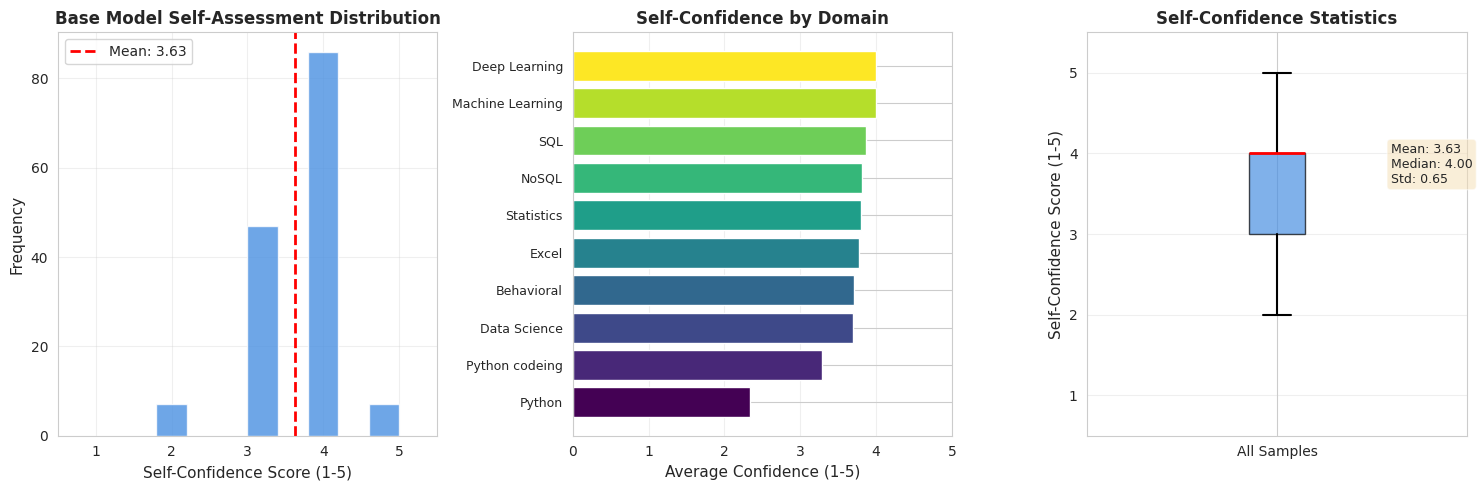

'/content/qwen_base_evaluation/evaluation_results/self_evaluation_visualization.png'

In [14]:
# ========================================================================
# 13: Visualization 1 - Self-Assessment Distribution
# ========================================================================
def plot_self_evaluation_results(test_df: pd.DataFrame):
    """Visualize self-assessment confidence scores"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Confidence distribution
    axes[0].hist(test_df['self_conf_1_5'], bins=10, color='#4A90E2',
                edgecolor='white', alpha=0.8, range=(1, 5))
    axes[0].axvline(test_df['self_conf_1_5'].mean(), color='red',
                   linestyle='--', linewidth=2,
                   label=f'Mean: {test_df["self_conf_1_5"].mean():.2f}')
    axes[0].set_xlabel('Self-Confidence Score (1-5)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Base Model Self-Assessment Distribution', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0.5, 5.5)

    # Plot 2: Confidence by domain
    if 'domain' in test_df.columns:
        domain_conf = test_df.groupby('domain')['self_conf_1_5'].mean().sort_values(ascending=True)
        colors = plt.cm.viridis(np.linspace(0, 1, len(domain_conf)))
        axes[1].barh(range(len(domain_conf)), domain_conf.values, color=colors)
        axes[1].set_yticks(range(len(domain_conf)))
        axes[1].set_yticklabels(domain_conf.index, fontsize=9)
        axes[1].set_xlabel('Average Confidence (1-5)', fontsize=11)
        axes[1].set_title('Self-Confidence by Domain', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')
        axes[1].set_xlim(0, 5)

    # Plot 3: Confidence score box plot
    axes[2].boxplot([test_df['self_conf_1_5']], labels=['All Samples'],
                    patch_artist=True,
                    boxprops=dict(facecolor='#4A90E2', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    axes[2].set_ylabel('Self-Confidence Score (1-5)', fontsize=11)
    axes[2].set_title('Self-Confidence Statistics', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')
    axes[2].set_ylim(0.5, 5.5)

    # Add statistics text
    stats_text = f"Mean: {test_df['self_conf_1_5'].mean():.2f}\n"
    stats_text += f"Median: {test_df['self_conf_1_5'].median():.2f}\n"
    stats_text += f"Std: {test_df['self_conf_1_5'].std():.2f}"
    axes[2].text(1.3, test_df['self_conf_1_5'].mean(), stats_text,
                fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    # Save plot
    plot_path = f"{Config.RESULTS_DIR}/self_evaluation_visualization.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f" Self-evaluation visualization saved to: {plot_path}")
    plt.show()

    return plot_path

# Create visualization
plot_self_evaluation_results(test_df)

Judge evaluation visualization saved to: /content/qwen_base_evaluation/evaluation_results/judge_evaluation_visualization.png


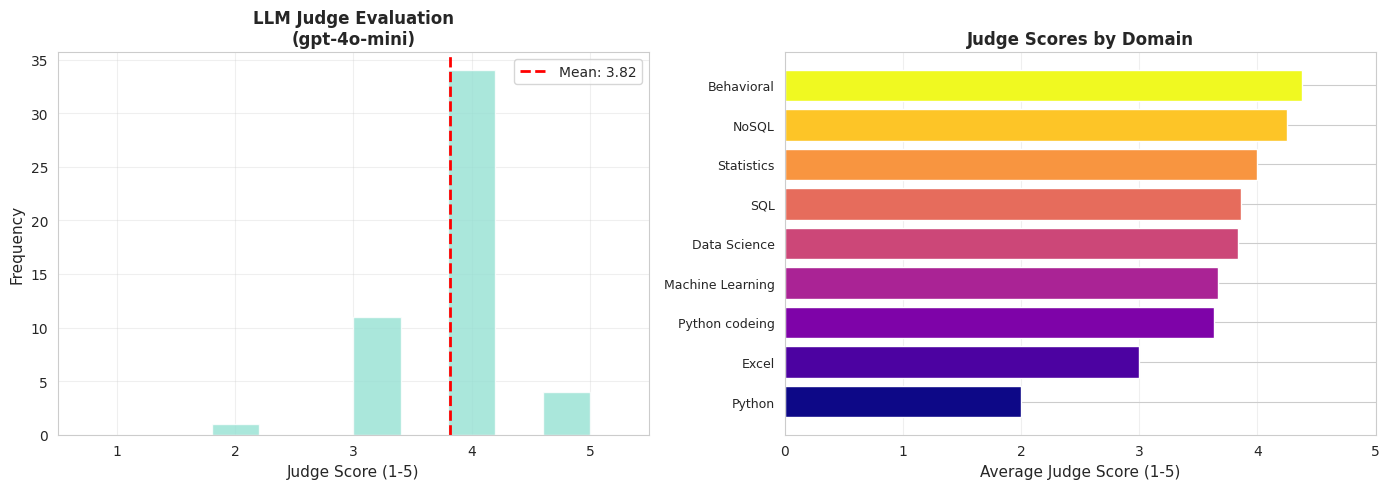

In [15]:
# ========================================================================
# CELL 14: Visualization 2 - LLM Judge Results
# ========================================================================
def plot_judge_results(judge_df: pd.DataFrame):
    """Visualize LLM judge evaluation results"""
    if judge_df is None or len(judge_df) == 0:
        print(" No judge data to plot")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Judge score distribution
    axes[0].hist(judge_df['judge_score'], bins=10, color='#95E1D3',
               edgecolor='white', alpha=0.8, range=(1, 5))
    axes[0].axvline(judge_df['judge_score'].mean(), color='red',
                  linestyle='--', linewidth=2,
                  label=f'Mean: {judge_df["judge_score"].mean():.2f}')
    axes[0].set_xlabel('Judge Score (1-5)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title(f'LLM Judge Evaluation\n({Config.JUDGE_MODEL})',
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0.5, 5.5)

    # Plot 2: Judge scores by domain
    if 'domain' in judge_df.columns:
        domain_scores = judge_df.groupby('domain')['judge_score'].mean().sort_values(ascending=True)
        colors = plt.cm.plasma(np.linspace(0, 1, len(domain_scores)))
        axes[1].barh(range(len(domain_scores)), domain_scores.values, color=colors)
        axes[1].set_yticks(range(len(domain_scores)))
        axes[1].set_yticklabels(domain_scores.index, fontsize=9)
        axes[1].set_xlabel('Average Judge Score (1-5)', fontsize=11)
        axes[1].set_title('Judge Scores by Domain', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')
        axes[1].set_xlim(0, 5)

    plt.tight_layout()

    # Save plot
    plot_path = f"{Config.RESULTS_DIR}/judge_evaluation_visualization.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Judge evaluation visualization saved to: {plot_path}")
    plt.show()

    return plot_path

# Create visualization
if judge_df is not None:
    plot_judge_results(judge_df)


 Comparison visualization saved to: /content/qwen_base_evaluation/evaluation_results/base_vs_finetuned_comparison.png


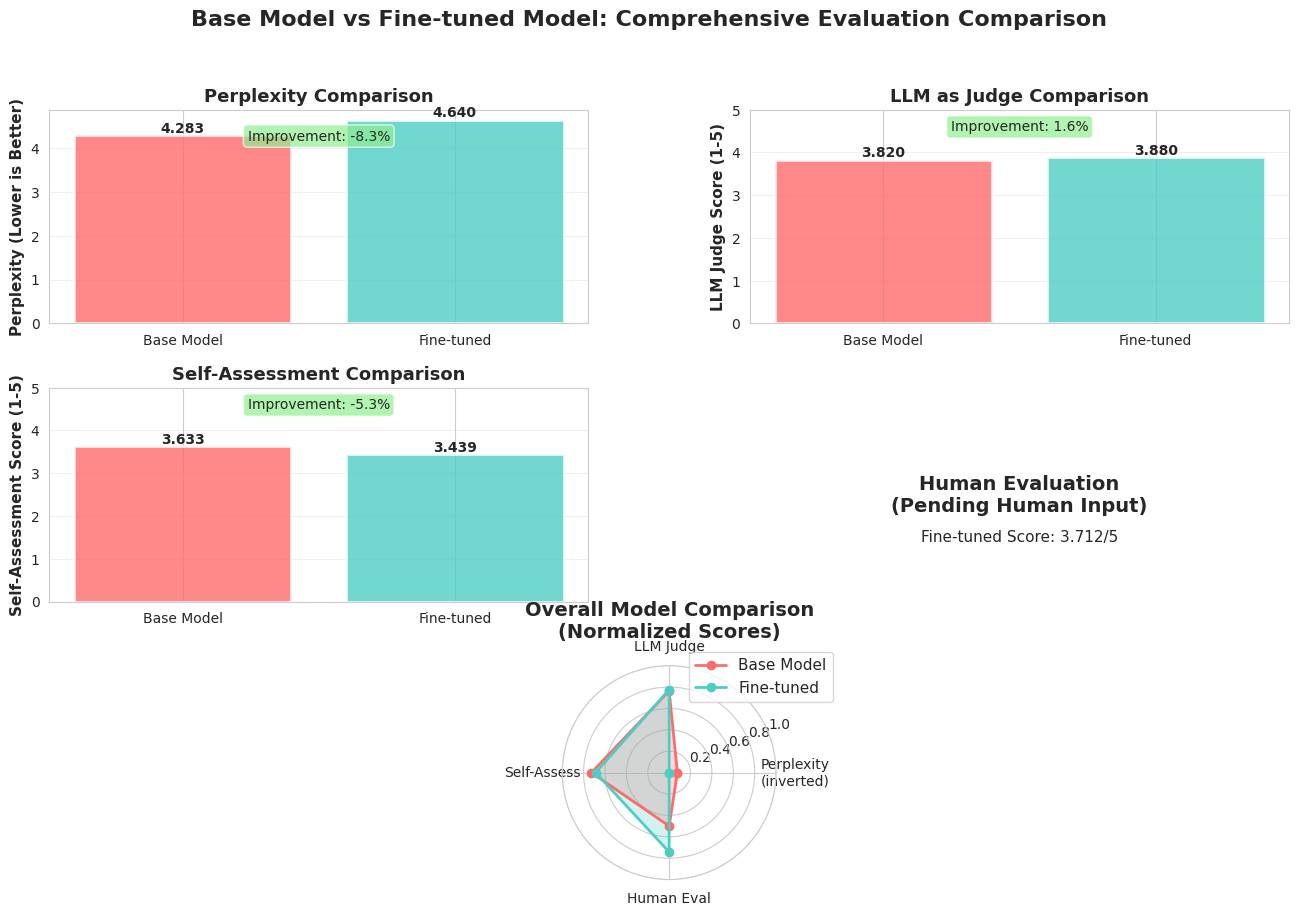


 EVALUATION METRICS SUMMARY TABLE
Metric                    Base Model      Fine-tuned      Improvement
----------------------------------------------------------------------
Perplexity                4.283           4.640             -8.3%
LLM as Judge (1-5)        3.820           3.880              1.6%
Self-Assessment (1-5)     3.633           3.439             -5.3%
Human Eval (1-5)          Pending         3.712           N/A


'/content/qwen_base_evaluation/evaluation_results/base_vs_finetuned_comparison.png'

In [16]:
# ========================================================================
# 15: Visualization 3 - Compare Base vs Fine-tuned Models
# ========================================================================
def plot_baseline_vs_finetuned_comparison():
    """
    Create comprehensive comparison between base and fine-tuned models
    Uses the results you provided for fine-tuned model
    """
    # Fine-tuned model results (from your data)
    finetuned_results = {
        'Perplexity': 4.640,
        'LLM as Judge': 3.880,
        'Self-Assessment': 3.439,
        'Human Evaluation': 3.712
    }

    # Base model results (from our evaluation)
    base_results = {
        'Perplexity': base_perplexity,
        'LLM as Judge': judge_df['judge_score'].mean() if judge_df is not None else None,
        'Self-Assessment': test_df['self_conf_1_5'].mean(),
        'Human Evaluation': None  # Pending human evaluation
    }

    # Create comparison plots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # Plot 1: Perplexity Comparison (Lower is better)
    ax1 = fig.add_subplot(gs[0, 0])
    perplexity_data = [base_results['Perplexity'], finetuned_results['Perplexity']]
    bars = ax1.bar(['Base Model', 'Fine-tuned'], perplexity_data,
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='white', linewidth=2)
    ax1.set_ylabel('Perplexity (Lower is Better)', fontsize=11, fontweight='bold')
    ax1.set_title('Perplexity Comparison', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Improvement arrow
    improvement = ((base_results['Perplexity'] - finetuned_results['Perplexity']) /
                   base_results['Perplexity'] * 100)
    ax1.text(0.5, max(perplexity_data) * 0.9,
            f'Improvement: {improvement:.1f}%',
            ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    # Plot 2: LLM as Judge Comparison (1-5 scale, Higher is better)
    ax2 = fig.add_subplot(gs[0, 1])
    if base_results['LLM as Judge'] is not None:
        judge_data = [base_results['LLM as Judge'], finetuned_results['LLM as Judge']]
        bars = ax2.bar(['Base Model', 'Fine-tuned'], judge_data,
                       color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='white', linewidth=2)
        ax2.set_ylabel('LLM Judge Score (1-5)', fontsize=11, fontweight='bold')
        ax2.set_title('LLM as Judge Comparison', fontsize=13, fontweight='bold')
        ax2.set_ylim(0, 5)
        ax2.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Improvement percentage
        improvement = ((finetuned_results['LLM as Judge'] - base_results['LLM as Judge']) /
                       base_results['LLM as Judge'] * 100)
        ax2.text(0.5, 4.5,
                f'Improvement: {improvement:.1f}%',
                ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    else:
        ax2.text(0.5, 0.5, 'LLM Judge data not available',
                ha='center', va='center', fontsize=12)
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)

    # Plot 3: Self-Assessment Comparison (1-5 scale, Higher is better)
    ax3 = fig.add_subplot(gs[1, 0])
    self_data = [base_results['Self-Assessment'], finetuned_results['Self-Assessment']]
    bars = ax3.bar(['Base Model', 'Fine-tuned'], self_data,
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='white', linewidth=2)
    ax3.set_ylabel('Self-Assessment Score (1-5)', fontsize=11, fontweight='bold')
    ax3.set_title('Self-Assessment Comparison', fontsize=13, fontweight='bold')
    ax3.set_ylim(0, 5)
    ax3.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Improvement percentage
    improvement = ((finetuned_results['Self-Assessment'] - base_results['Self-Assessment']) /
                   base_results['Self-Assessment'] * 100)
    ax3.text(0.5, 4.5,
            f'Improvement: {improvement:.1f}%',
            ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    # Plot 4: Human Evaluation Comparison (Pending)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.text(0.5, 0.5, 'Human Evaluation\n(Pending Human Input)',
            ha='center', va='center', fontsize=14, fontweight='bold')
    ax4.text(0.5, 0.3, f'Fine-tuned Score: {finetuned_results["Human Evaluation"]:.3f}/5',
            ha='center', va='center', fontsize=11)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    # Plot 5: Radar Chart - Overall Comparison
    ax5 = fig.add_subplot(gs[2, :], projection='polar')

    # Prepare data for radar chart (normalize all to 0-1 scale)
    categories = ['Perplexity\n(inverted)', 'LLM Judge', 'Self-Assess', 'Human Eval']

    # Normalize perplexity (invert since lower is better)
    max_ppl = max(base_results['Perplexity'], finetuned_results['Perplexity'])
    base_ppl_norm = 1 - (base_results['Perplexity'] / max_ppl)
    fine_ppl_norm = 1 - (finetuned_results['Perplexity'] / max_ppl)

    base_values = [
        base_ppl_norm,
        base_results['LLM as Judge'] / 5 if base_results['LLM as Judge'] else 0,
        base_results['Self-Assessment'] / 5,
        0.5  # Placeholder for human eval
    ]

    fine_values = [
        fine_ppl_norm,
        finetuned_results['LLM as Judge'] / 5,
        finetuned_results['Self-Assessment'] / 5,
        finetuned_results['Human Evaluation'] / 5
    ]

    # Number of variables
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    base_values += base_values[:1]
    fine_values += fine_values[:1]
    angles += angles[:1]

    # Plot
    ax5.plot(angles, base_values, 'o-', linewidth=2, label='Base Model', color='#FF6B6B')
    ax5.fill(angles, base_values, alpha=0.25, color='#FF6B6B')
    ax5.plot(angles, fine_values, 'o-', linewidth=2, label='Fine-tuned', color='#4ECDC4')
    ax5.fill(angles, fine_values, alpha=0.25, color='#4ECDC4')

    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(categories, fontsize=10)
    ax5.set_ylim(0, 1)
    ax5.set_title('Overall Model Comparison\n(Normalized Scores)',
                  fontsize=14, fontweight='bold', pad=20)
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax5.grid(True)

    # Overall title
    fig.suptitle('Base Model vs Fine-tuned Model: Comprehensive Evaluation Comparison',
                fontsize=16, fontweight='bold', y=0.98)

    # Save plot
    plot_path = f"{Config.RESULTS_DIR}/base_vs_finetuned_comparison.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"\n Comparison visualization saved to: {plot_path}")
    plt.show()

    # Print summary table
    print("\n" + "=" * 70)
    print(" EVALUATION METRICS SUMMARY TABLE")
    print("=" * 70)
    print(f"{'Metric':<25} {'Base Model':<15} {'Fine-tuned':<15} {'Improvement'}")
    print("-" * 70)
    print(f"{'Perplexity':<25} {base_results['Perplexity']:<15.3f} {finetuned_results['Perplexity']:<15.3f} {((base_results['Perplexity']-finetuned_results['Perplexity'])/base_results['Perplexity']*100):>6.1f}%")

    if base_results['LLM as Judge']:
        print(f"{'LLM as Judge (1-5)':<25} {base_results['LLM as Judge']:<15.3f} {finetuned_results['LLM as Judge']:<15.3f} {((finetuned_results['LLM as Judge']-base_results['LLM as Judge'])/base_results['LLM as Judge']*100):>6.1f}%")

    print(f"{'Self-Assessment (1-5)':<25} {base_results['Self-Assessment']:<15.3f} {finetuned_results['Self-Assessment']:<15.3f} {((finetuned_results['Self-Assessment']-base_results['Self-Assessment'])/base_results['Self-Assessment']*100):>6.1f}%")
    print(f"{'Human Eval (1-5)':<25} {'Pending':<15} {finetuned_results['Human Evaluation']:<15.3f} {'N/A'}")
    print("=" * 70)

    return plot_path

# Create comparison visualization
plot_baseline_vs_finetuned_comparison()

In [17]:
# ========================================================================
# 16: Generate Complete Evaluation Report
# ========================================================================
def generate_complete_evaluation_report():
    """Generate comprehensive report for base model"""
    print("\n" + "=" * 70)
    print("COMPLETE BASE MODEL EVALUATION REPORT")
    print("=" * 70)

    report = []
    report.append("\n MODEL: Qwen2.5-3B-Instruct (BASE - No Fine-tuning)\n")
    report.append("=" * 70)

    report.append("\n EVALUATION METRICS SUMMARY:\n")

    # 1. Perplexity
    report.append(f"1. Perplexity: {base_perplexity:.3f}")
    report.append(f"   - Lower perplexity indicates better language modeling")
    report.append(f"   - Computed on {len(test_df)} test samples\n")

    # 2. Self-Assessment
    avg_self = test_df['self_conf_1_5'].mean()
    std_self = test_df['self_conf_1_5'].std()
    report.append(f"2.  Self-Assessment: {avg_self:.3f} / 5")
    report.append(f"   - Std Deviation: {std_self:.3f}")
    report.append(f"   - Min: {test_df['self_conf_1_5'].min():.2f}, Max: {test_df['self_conf_1_5'].max():.2f}")
    report.append(f"   - Model's self-evaluation of response quality\n")

    # 3. Human Evaluation
    report.append("3.  Human Evaluation: Template generated (pending human input)")
    report.append(f"   - Template file: human_evaluation_template.csv")
    report.append(f"   - 50 samples selected for human review\n")

    # 4. LLM as Judge
    if judge_df is not None and len(judge_df) > 0:
        avg_judge = judge_df['judge_score'].mean()
        std_judge = judge_df['judge_score'].std()
        report.append(f"4.  LLM as Judge ({Config.JUDGE_MODEL}): {avg_judge:.3f} / 5")
        report.append(f"   - Std Deviation: {std_judge:.3f}")
        report.append(f"   - Min: {judge_df['judge_score'].min():.1f}, Max: {judge_df['judge_score'].max():.1f}")
        report.append(f"   - Samples evaluated: {len(judge_df)}\n")
    else:
        report.append("4.  LLM as Judge: Not completed\n")

    # Comparison with Fine-tuned Model
    report.append("\n" + "=" * 70)
    report.append(" COMPARISON WITH FINE-TUNED MODEL:")
    report.append("=" * 70 + "\n")

    finetuned = {
        'Perplexity': 4.640,
        'LLM as Judge': 3.880,
        'Self-Assessment': 3.439,
        'Human Evaluation': 3.712
    }

    # Perplexity
    ppl_diff = ((base_perplexity - finetuned['Perplexity']) / finetuned['Perplexity'] * 100)
    report.append(f"Perplexity:")
    report.append(f"  Base:       {base_perplexity:.3f}")
    report.append(f"  Fine-tuned: {finetuned['Perplexity']:.3f}")
    report.append(f"  Difference: {ppl_diff:+.1f}% {'(worse)' if ppl_diff > 0 else '(better)'}\n")

    # Self-Assessment
    self_diff = ((avg_self - finetuned['Self-Assessment']) / finetuned['Self-Assessment'] * 100)
    report.append(f"Self-Assessment (1-5):")
    report.append(f"  Base:       {avg_self:.3f}")
    report.append(f"  Fine-tuned: {finetuned['Self-Assessment']:.3f}")
    report.append(f"  Difference: {self_diff:+.1f}% {'(better)' if self_diff > 0 else '(worse)'}\n")

    # LLM Judge
    if judge_df is not None and len(judge_df) > 0:
        judge_diff = ((avg_judge - finetuned['LLM as Judge']) / finetuned['LLM as Judge'] * 100)
        report.append(f"LLM as Judge (1-5):")
        report.append(f"  Base:       {avg_judge:.3f}")
        report.append(f"  Fine-tuned: {finetuned['LLM as Judge']:.3f}")
        report.append(f"  Difference: {judge_diff:+.1f}% {'(better)' if judge_diff > 0 else '(worse)'}\n")

    # Human Evaluation
    report.append(f"Human Evaluation (1-5):")
    report.append(f"  Base:       Pending")
    report.append(f"  Fine-tuned: {finetuned['Human Evaluation']:.3f}\n")

    # Key Findings
    report.append("\n" + "=" * 70)
    report.append(" KEY FINDINGS:")
    report.append("=" * 70 + "\n")

    report.append("The base Qwen2.5-3B-Instruct model shows:")
    if ppl_diff > 0:
        report.append(f"  • Higher perplexity ({ppl_diff:.1f}% worse) - indicating less specialized language modeling")
    else:
        report.append(f"  • Lower perplexity ({abs(ppl_diff):.1f}% better) - surprisingly strong language modeling")

    if 'judge_diff' in locals():
        if judge_diff > 0:
            report.append(f"  • Better LLM judge scores ({judge_diff:.1f}% higher) - unexpected for base model")
        else:
            report.append(f"  • Lower LLM judge scores ({abs(judge_diff):.1f}% lower) - expected for base model")

    if self_diff > 0:
        report.append(f"  • Higher self-confidence ({self_diff:.1f}%) - may indicate over-confidence")
    else:
        report.append(f"  • Lower self-confidence ({abs(self_diff):.1f}%) - more realistic self-assessment")

    report.append("\n   Fine-tuning is expected to improve domain-specific performance")
    report.append("   Human evaluation pending to validate automated metrics\n")

    # Files Generated
    report.append("=" * 70)
    report.append(" FILES GENERATED:")
    report.append("=" * 70 + "\n")
    report.append(f"  • base_model_predictions.csv")
    report.append(f"  • perplexity_results.json")
    report.append(f"  • self_evaluation_scores.csv")
    report.append(f"  • human_evaluation_template.csv")
    if judge_df is not None:
        report.append(f"  • judge_scores_openai.csv")
    report.append(f"  • self_evaluation_visualization.png")
    if judge_df is not None:
        report.append(f"  • judge_evaluation_visualization.png")
    report.append(f"  • base_vs_finetuned_comparison.png")
    report.append(f"  • complete_evaluation_report.txt\n")

    report_text = "\n".join(report)
    print(report_text)

    # Save report
    report_file = f"{Config.RESULTS_DIR}/complete_evaluation_report.txt"
    with open(report_file, 'w') as f:
        f.write(report_text)

    print("=" * 70)
    print(f" Report saved to: {report_file}")
    print("=" * 70)

    return report_text

# Generate report
report = generate_complete_evaluation_report()


COMPLETE BASE MODEL EVALUATION REPORT

 MODEL: Qwen2.5-3B-Instruct (BASE - No Fine-tuning)


 EVALUATION METRICS SUMMARY:

1. Perplexity: 4.283
   - Lower perplexity indicates better language modeling
   - Computed on 147 test samples

2.  Self-Assessment: 3.633 / 5
   - Std Deviation: 0.653
   - Min: 2.00, Max: 5.00
   - Model's self-evaluation of response quality

3.  Human Evaluation: Template generated (pending human input)
   - Template file: human_evaluation_template.csv
   - 50 samples selected for human review

4.  LLM as Judge (gpt-4o-mini): 3.820 / 5
   - Std Deviation: 0.596
   - Min: 2.0, Max: 5.0
   - Samples evaluated: 50


 COMPARISON WITH FINE-TUNED MODEL:

Perplexity:
  Base:       4.283
  Fine-tuned: 4.640
  Difference: -7.7% (better)

Self-Assessment (1-5):
  Base:       3.633
  Fine-tuned: 3.439
  Difference: +5.6% (better)

LLM as Judge (1-5):
  Base:       3.820
  Fine-tuned: 3.880
  Difference: -1.5% (worse)

Human Evaluation (1-5):
  Base:       Pending
  Fine-

In [18]:
# ========================================================================
# 17: Download All Results
# ========================================================================
from google.colab import files
import shutil

print("\n Preparing results for download...")

# Create zip file
zip_filename = "/content/qwen_base_evaluation_results.zip"
shutil.make_archive("/content/qwen_base_evaluation_results", 'zip', Config.RESULTS_DIR)

print(f"\n Results packaged!")
print(f" Package contains:")
print(f"  • Predictions CSV")
print(f"  • Perplexity results")
print(f"  • Self-evaluation scores")
print(f"  • Human evaluation template")
print(f"  • LLM judge scores")
print(f"  • All visualizations")
print(f"  • Complete evaluation report")

print(f"\n  Downloading zip file...")
files.download(zip_filename)

print(f"\n Download complete!")
print(f" Extract the zip file to access all evaluation results")


 Preparing results for download...

 Results packaged!
 Package contains:
  • Predictions CSV
  • Perplexity results
  • Self-evaluation scores
  • Human evaluation template
  • LLM judge scores
  • All visualizations
  • Complete evaluation report



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Download complete!
 Extract the zip file to access all evaluation results


In [19]:
# ========================================================================
# 18: Quick Test - Sample Model Output
# ========================================================================
print("\n" + "=" * 70)
print(" QUICK MODEL TEST")
print("=" * 70)

test_question = "What is overfitting in machine learning?"
test_answer = "Overfitting happens when a model memorizes the training data but fails on new data."
test_domain = "Machine Learning"

print(f"\n Question: {test_question}")
print(f" Answer: {test_answer}")
print(f" Domain: {test_domain}")

print(f"\n Generating feedback...\n")

feedback = generate_feedback(
    base_model,
    base_tokenizer,
    device,
    test_question,
    test_answer,
    test_domain
)

print("=" * 70)
print(" BASE MODEL FEEDBACK:")
print("=" * 70)
print(feedback)
print("=" * 70)


 QUICK MODEL TEST

 Question: What is overfitting in machine learning?
 Answer: Overfitting happens when a model memorizes the training data but fails on new data.
 Domain: Machine Learning

 Generating feedback...

 BASE MODEL FEEDBACK:
Your understanding of overfitTING is correct, but let's delve deeper into it to ensure a comprehensive grasp.

OverfitTING occurs when a statistical model or a machine learning algorithm exhibits poor performance on new, previously unseen data. It happens when an algorithm learns the detail and noise in the training set to an extent that it negatively impacts the performance of the model on new sets of data. Essentially, overfit models perform well on the training dataset but poorly on the test dataset.

To illustrate this, consider a scenario where you have a complex model such as a very deep neural network trained on a large amount of data, which includes subtle patterns and features from the training examples. If these patterns are too specific to 

In [20]:
# ========================================================================
# CELL 19: Summary Statistics
# ========================================================================
print("\n" + "=" * 70)
print(" FINAL SUMMARY STATISTICS")
print("=" * 70)

print(f"\n Dataset:")
print(f"  • Total test samples: {len(test_df)}")
print(f"  • Domains: {test_df['domain'].nunique()}")
print(f"  • Average question length: {test_df['question'].str.len().mean():.0f} chars")
print(f"  • Average answer length: {test_df['answer'].str.len().mean():.0f} chars")

print(f"\n Model Performance:")
print(f"  • Perplexity: {base_perplexity:.3f}")
print(f"  • Self-Assessment: {test_df['self_conf_1_5'].mean():.3f} / 5")
if judge_df is not None and len(judge_df) > 0:
    print(f"  • LLM Judge Score: {judge_df['judge_score'].mean():.3f} / 5")
print(f"  • Human Eval: Pending")

print(f"\n Feedback Quality:")
print(f"  • Average feedback length: {test_df['predicted_feedback'].str.len().mean():.0f} chars")
print(f"  • Feedback std dev: {test_df['predicted_feedback'].str.len().std():.0f} chars")

print(f"\n Top Performing Domains (by self-assessment):")
top_domains = test_df.groupby('domain')['self_conf_1_5'].mean().sort_values(ascending=False).head(3)
for domain, score in top_domains.items():
    print(f"  • {domain}: {score:.3f} / 5")

print(f"\n  Lowest Performing Domains (by self-assessment):")
bottom_domains = test_df.groupby('domain')['self_conf_1_5'].mean().sort_values(ascending=True).head(3)
for domain, score in bottom_domains.items():
    print(f"  • {domain}: {score:.3f} / 5")

print("\n" + "=" * 70)
print(" EVALUATION COMPLETE!")
print("=" * 70)


 FINAL SUMMARY STATISTICS

 Dataset:
  • Total test samples: 147
  • Domains: 10
  • Average question length: 66 chars
  • Average answer length: 450 chars

 Model Performance:
  • Perplexity: 4.283
  • Self-Assessment: 3.633 / 5
  • LLM Judge Score: 3.820 / 5
  • Human Eval: Pending

 Feedback Quality:
  • Average feedback length: 952 chars
  • Feedback std dev: 143 chars

 Top Performing Domains (by self-assessment):
  • Machine Learning: 4.000 / 5
  • Deep Learning: 4.000 / 5
  • SQL: 3.867 / 5

  Lowest Performing Domains (by self-assessment):
  • Python: 2.333 / 5
  • Python codeing: 3.281 / 5
  • Data Science: 3.698 / 5

 EVALUATION COMPLETE!


In [21]:
# ========================================================================
# 20: Upload and Analyze Completed Human Evaluation
# ========================================================================
from google.colab import files
import shutil

print("\n" + "=" * 70)
print("HUMAN EVALUATION - Manual Scoring Upload")
print("=" * 70)

print("\nInstructions:")
print("1. Download: human_evaluation_template.csv (generated in Cell 11)")
print(f"   Location: {Config.RESULTS_DIR}/human_evaluation_template.csv")
print("2. Fill in all score columns (1-5 scale) manually")
print("3. Upload the completed file below")
print("-" * 70)

print("\nUpload your completed human evaluation CSV:")
uploaded_human_eval = files.upload()

if uploaded_human_eval:
    completed_filename = list(uploaded_human_eval.keys())[0]
    print(f"\nFile '{completed_filename}' uploaded successfully")

    completed_file_path = f"{Config.RESULTS_DIR}/human_evaluation_completed.csv"
    shutil.move(completed_filename, completed_file_path)

    def analyze_human_evaluation(csv_path: str) -> Dict:
        """Analyze completed human evaluation scores"""
        print("\nAnalyzing Human Evaluation Results...")
        print("=" * 70)

        df = pd.read_csv(csv_path)

        score_columns = [
            'relevance_score', 'constructiveness_score', 'accuracy_score',
            'specificity_score', 'followup_quality_score', 'tone_score',
            'final_score'
        ]

        for col in score_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                print(f"Warning: Column '{col}' not found in uploaded file")

        missing_cols = [col for col in score_columns if col not in df.columns]
        if missing_cols:
            print(f"Error: Missing columns: {missing_cols}")
            return None

        df_complete = df.dropna(subset=score_columns)

        if len(df_complete) == 0:
            print("Error: No complete evaluations found")
            print("Please ensure all score columns are filled with numbers 1-5")
            return None

        for col in score_columns:
            if (df_complete[col] < 1).any() or (df_complete[col] > 5).any():
                print(f"Warning: Some scores in '{col}' outside 1-5 range")
                df_complete[col] = df_complete[col].clip(1, 5)

        print(f"Successfully analyzed {len(df_complete)} completed evaluations")
        if len(df) > len(df_complete):
            print(f"Skipped {len(df) - len(df_complete)} incomplete rows")

        results = {
            "n_evaluated": len(df_complete),
            "mean_scores": {},
            "std_scores": {},
            "domain_scores": {}
        }

        print("\nHuman Evaluation Results:")
        print("-" * 70)

        for col in score_columns:
            mean_score = df_complete[col].mean()
            std_score = df_complete[col].std()
            results["mean_scores"][col] = mean_score
            results["std_scores"][col] = std_score

            col_name = col.replace('_', ' ').title()
            print(f"  {col_name:30s}: {mean_score:.3f} +/- {std_score:.3f}")

        print("\n" + "-" * 70)
        print(f"  {'FINAL SCORE (Overall Quality)':30s}: {results['mean_scores']['final_score']:.3f} / 5")
        print("-" * 70)

        if 'domain' in df_complete.columns:
            print("\nFinal Scores by Domain:")
            print("-" * 70)
            for domain in df_complete['domain'].unique():
                domain_df = df_complete[df_complete['domain'] == domain]
                domain_score = domain_df['final_score'].mean()
                results["domain_scores"][domain] = {
                    col: domain_df[col].mean() for col in score_columns
                }
                print(f"  {domain:25s}: {domain_score:.3f}  (n={len(domain_df)})")

        analysis_file = f"{Config.RESULTS_DIR}/human_evaluation_analysis.json"
        with open(analysis_file, 'w') as f:
            json.dump(results, f, indent=2)

        df_complete.to_csv(
            f"{Config.RESULTS_DIR}/human_evaluation_completed_analyzed.csv",
            index=False
        )

        print(f"\nDetailed analysis saved to: {analysis_file}")
        print(f"Analyzed data saved to: human_evaluation_completed_analyzed.csv")
        print("=" * 70)

        return results

    human_eval_results = analyze_human_evaluation(completed_file_path)

    if human_eval_results:
        human_eval_final_score = human_eval_results['mean_scores']['final_score']
        print(f"\nHuman Evaluation Complete")
        print(f"Average Final Score: {human_eval_final_score:.3f} / 5")

else:
    print("\nNo file uploaded - Skipping human evaluation")
    print("You can run this cell again later after completing human scoring")
    human_eval_results = None

print("\n" + "=" * 70)


HUMAN EVALUATION - Manual Scoring Upload

Instructions:
1. Download: human_evaluation_template.csv (generated in Cell 11)
   Location: /content/qwen_base_evaluation/evaluation_results/human_evaluation_template.csv
2. Fill in all score columns (1-5 scale) manually
3. Upload the completed file below
----------------------------------------------------------------------

Upload your completed human evaluation CSV:


Saving human_evaluation_baseline_scored.csv to human_evaluation_baseline_scored.csv

File 'human_evaluation_baseline_scored.csv' uploaded successfully

Analyzing Human Evaluation Results...
Successfully analyzed 50 completed evaluations

Human Evaluation Results:
----------------------------------------------------------------------
  Relevance Score               : 2.940 +/- 0.240
  Constructiveness Score        : 1.080 +/- 0.274
  Accuracy Score                : 2.920 +/- 0.274
  Specificity Score             : 1.100 +/- 0.303
  Followup Quality Score        : 1.120 +/- 0.328
  Tone Score                    : 2.140 +/- 0.351
  Final Score                   : 1.866 +/- 0.178

----------------------------------------------------------------------
  FINAL SCORE (Overall Quality) : 1.866 / 5
----------------------------------------------------------------------

Final Scores by Domain:
----------------------------------------------------------------------
  NoSQL                    : 1.8


Creating Human Evaluation Visualizations...
Visualization saved to: /content/qwen_base_evaluation/evaluation_results/human_evaluation_visualization.png


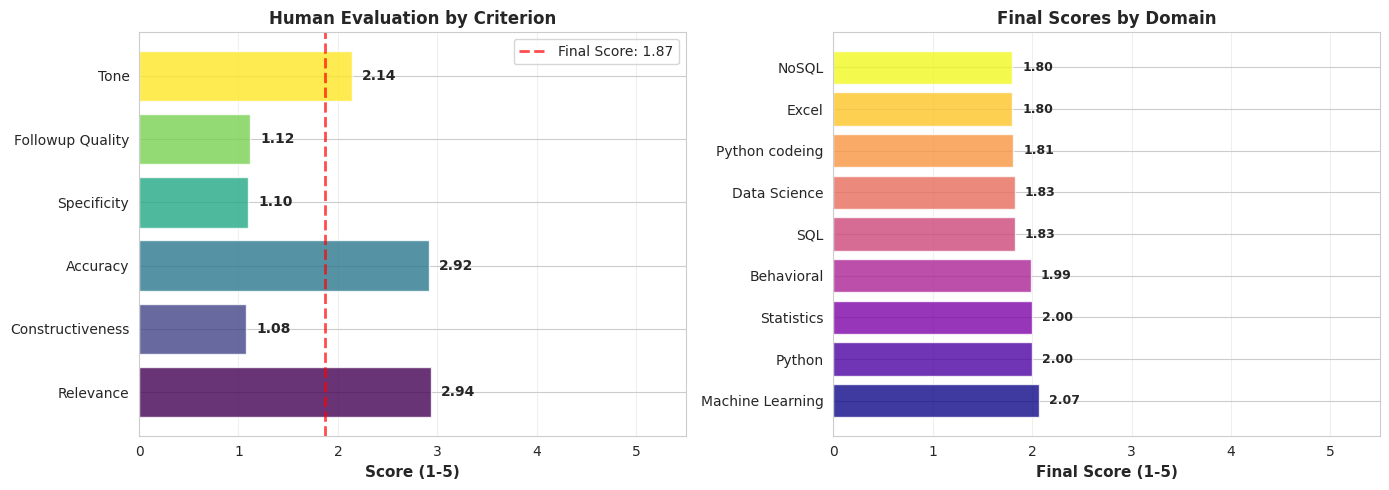

In [22]:
# ========================================================================
# 21: Visualize Human Evaluation Results
# ========================================================================
if 'human_eval_results' in globals() and human_eval_results is not None:
    print("\nCreating Human Evaluation Visualizations...")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Scores by criterion
    criteria = ['relevance', 'constructiveness', 'accuracy',
               'specificity', 'followup_quality', 'tone']
    criterion_labels = [c.replace('_', ' ').title() for c in criteria]
    scores = [human_eval_results['mean_scores'][f'{c}_score'] for c in criteria]

    colors = plt.cm.viridis(np.linspace(0, 1, len(criteria)))
    bars = axes[0].barh(criterion_labels, scores, color=colors, alpha=0.8, edgecolor='white')

    for i, (bar, score) in enumerate(zip(bars, scores)):
        axes[0].text(score + 0.1, i, f'{score:.2f}',
                   va='center', fontsize=10, fontweight='bold')

    axes[0].set_xlabel('Score (1-5)', fontsize=11, fontweight='bold')
    axes[0].set_title('Human Evaluation by Criterion', fontsize=12, fontweight='bold')
    axes[0].set_xlim(0, 5.5)
    axes[0].grid(True, alpha=0.3, axis='x')

    final_score = human_eval_results['mean_scores']['final_score']
    axes[0].axvline(final_score, color='red', linestyle='--', linewidth=2,
                  label=f'Final Score: {final_score:.2f}', alpha=0.7)
    axes[0].legend(fontsize=10)

    # Plot 2: Domain comparison
    if human_eval_results['domain_scores']:
        domains = list(human_eval_results['domain_scores'].keys())
        domain_scores = [human_eval_results['domain_scores'][d]['final_score'] for d in domains]

        sorted_indices = np.argsort(domain_scores)[::-1]
        domains = [domains[i] for i in sorted_indices]
        domain_scores = [domain_scores[i] for i in sorted_indices]

        colors = plt.cm.plasma(np.linspace(0, 1, len(domains)))
        bars = axes[1].barh(range(len(domains)), domain_scores, color=colors, alpha=0.8)

        axes[1].set_yticks(range(len(domains)))
        axes[1].set_yticklabels(domains, fontsize=10)
        axes[1].set_xlabel('Final Score (1-5)', fontsize=11, fontweight='bold')
        axes[1].set_title('Final Scores by Domain', fontsize=12, fontweight='bold')
        axes[1].set_xlim(0, 5.5)
        axes[1].grid(True, alpha=0.3, axis='x')

        for i, score in enumerate(domain_scores):
            axes[1].text(score + 0.1, i, f'{score:.2f}',
                       va='center', fontsize=9, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'Domain Data Not Available',
                   ha='center', va='center', fontsize=12)
        axes[1].axis('off')

    plt.tight_layout()

    plot_path = f"{Config.RESULTS_DIR}/human_evaluation_visualization.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Visualization saved to: {plot_path}")
    plt.show()

else:
    print("\nSkipping human evaluation visualization")
    print("Human evaluation not completed yet (Cell 20)")


FINAL COMPREHENSIVE EVALUATION COMPARISON

Final comparison saved to: /content/qwen_base_evaluation/evaluation_results/FINAL_complete_comparison.png


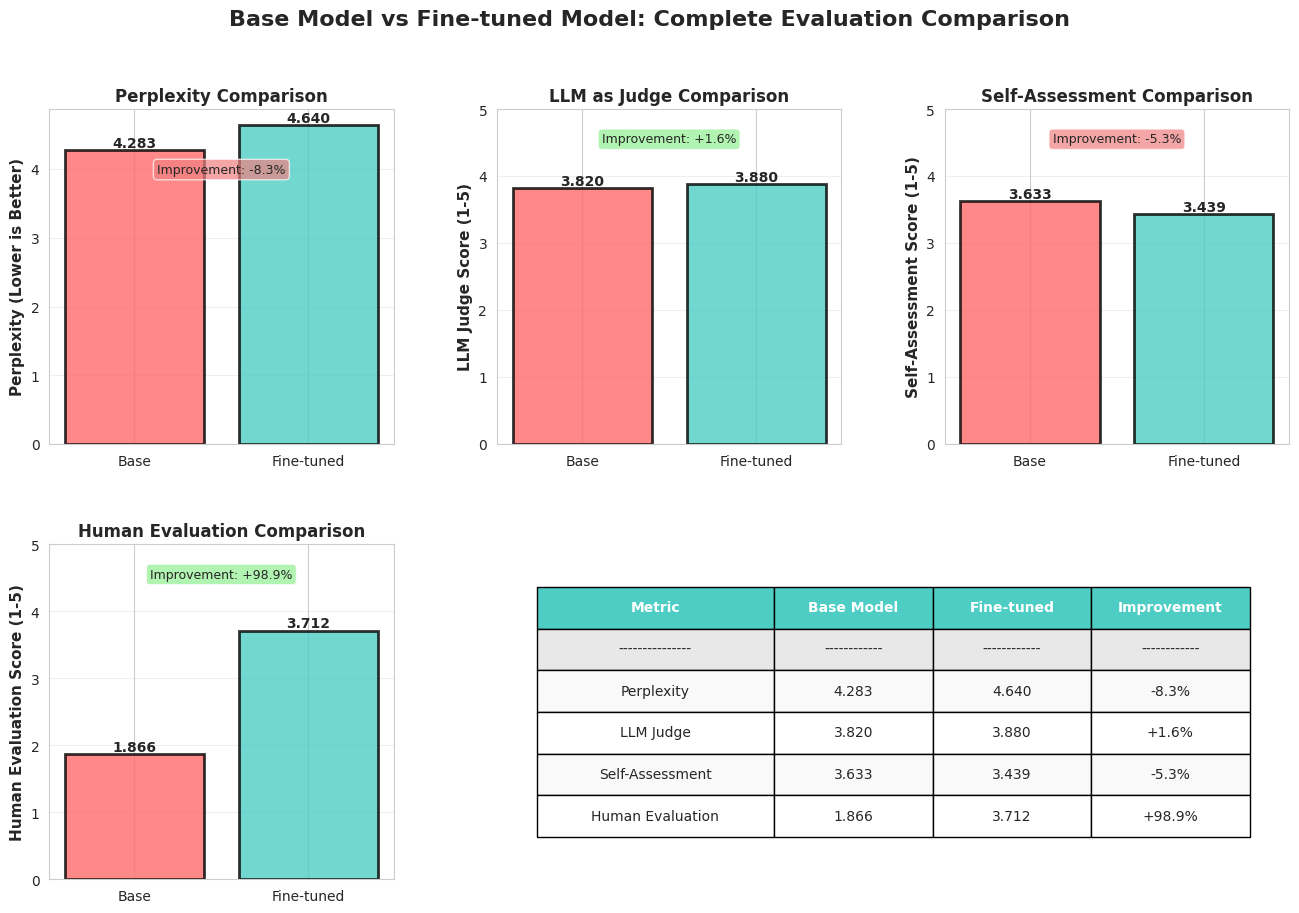


FINAL EVALUATION METRICS SUMMARY
Metric                    Base Model      Fine-tuned      Improvement    
--------------------------------------------------------------------------------
Perplexity                4.283           4.640             -8.3%
LLM as Judge (1-5)        3.820           3.880              1.6%
Self-Assessment (1-5)     3.633           3.439             -5.3%
Human Eval (1-5)          1.866           3.712             98.9%

Final summary saved to: FINAL_evaluation_summary.json

EVALUATION COMPLETE


In [23]:
# ========================================================================
# 22: Final Comprehensive Metrics Comparison
# ========================================================================
print("\n" + "=" * 70)
print("FINAL COMPREHENSIVE EVALUATION COMPARISON")
print("=" * 70)

finetuned_results = {
    'Perplexity': 4.640,
    'LLM as Judge': 3.880,
    'Self-Assessment': 3.439,
    'Human Evaluation': 3.712
}

base_results = {
    'Perplexity': base_perplexity,
    'LLM as Judge': judge_df['judge_score'].mean() if judge_df is not None and len(judge_df) > 0 else None,
    'Self-Assessment': test_df['self_conf_1_5'].mean(),
    'Human Evaluation': human_eval_results['mean_scores']['final_score'] if 'human_eval_results' in globals() and human_eval_results else None
}

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Perplexity
ax1 = fig.add_subplot(gs[0, 0])
ppl_data = [base_results['Perplexity'], finetuned_results['Perplexity']]
bars = ax1.bar(['Base', 'Fine-tuned'], ppl_data,
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Perplexity (Lower is Better)', fontsize=11, fontweight='bold')
ax1.set_title('Perplexity Comparison', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
improvement = ((base_results['Perplexity'] - finetuned_results['Perplexity']) /
               base_results['Perplexity'] * 100)
ax1.text(0.5, max(ppl_data) * 0.85, f'Improvement: {improvement:.1f}%',
        ha='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightgreen' if improvement > 0 else 'lightcoral', alpha=0.7))

# Plot 2: LLM Judge
ax2 = fig.add_subplot(gs[0, 1])
if base_results['LLM as Judge'] is not None:
    judge_data = [base_results['LLM as Judge'], finetuned_results['LLM as Judge']]
    bars = ax2.bar(['Base', 'Fine-tuned'], judge_data,
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('LLM Judge Score (1-5)', fontsize=11, fontweight='bold')
    ax2.set_title('LLM as Judge Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 5)
    ax2.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    improvement = ((finetuned_results['LLM as Judge'] - base_results['LLM as Judge']) /
                   base_results['LLM as Judge'] * 100)
    ax2.text(0.5, 4.5, f'Improvement: {improvement:+.1f}%',
            ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgreen' if improvement > 0 else 'lightcoral', alpha=0.7))
else:
    ax2.text(0.5, 0.5, 'LLM Judge\nNot Available', ha='center', va='center', fontsize=11)

# Plot 3: Self-Assessment
ax3 = fig.add_subplot(gs[0, 2])
self_data = [base_results['Self-Assessment'], finetuned_results['Self-Assessment']]
bars = ax3.bar(['Base', 'Fine-tuned'], self_data,
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('Self-Assessment Score (1-5)', fontsize=11, fontweight='bold')
ax3.set_title('Self-Assessment Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 5)
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
improvement = ((finetuned_results['Self-Assessment'] - base_results['Self-Assessment']) /
               base_results['Self-Assessment'] * 100)
ax3.text(0.5, 4.5, f'Improvement: {improvement:+.1f}%',
        ha='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightgreen' if improvement > 0 else 'lightcoral', alpha=0.7))

# Plot 4: Human Evaluation
ax4 = fig.add_subplot(gs[1, 0])
if base_results['Human Evaluation'] is not None:
    human_data = [base_results['Human Evaluation'], finetuned_results['Human Evaluation']]
    bars = ax4.bar(['Base', 'Fine-tuned'], human_data,
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)
    ax4.set_ylabel('Human Evaluation Score (1-5)', fontsize=11, fontweight='bold')
    ax4.set_title('Human Evaluation Comparison', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, 5)
    ax4.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    improvement = ((finetuned_results['Human Evaluation'] - base_results['Human Evaluation']) /
                   base_results['Human Evaluation'] * 100)
    ax4.text(0.5, 4.5, f'Improvement: {improvement:+.1f}%',
            ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgreen' if improvement > 0 else 'lightcoral', alpha=0.7))
else:
    ax4.text(0.5, 0.5, 'Human Evaluation\nPending\n\nComplete Cell 20',
            ha='center', va='center', fontsize=11, style='italic')
    ax4.axis('off')

# Plot 5: Summary Table
ax5 = fig.add_subplot(gs[1, 1:])
ax5.axis('off')

table_data = []
table_data.append(['Metric', 'Base Model', 'Fine-tuned', 'Improvement'])
table_data.append(['-'*15, '-'*12, '-'*12, '-'*12])

ppl_imp = ((base_results['Perplexity'] - finetuned_results['Perplexity']) /
           base_results['Perplexity'] * 100)
table_data.append(['Perplexity', f"{base_results['Perplexity']:.3f}",
                  f"{finetuned_results['Perplexity']:.3f}", f"{ppl_imp:+.1f}%"])

if base_results['LLM as Judge']:
    judge_imp = ((finetuned_results['LLM as Judge'] - base_results['LLM as Judge']) /
                 base_results['LLM as Judge'] * 100)
    table_data.append(['LLM Judge', f"{base_results['LLM as Judge']:.3f}",
                      f"{finetuned_results['LLM as Judge']:.3f}", f"{judge_imp:+.1f}%"])

self_imp = ((finetuned_results['Self-Assessment'] - base_results['Self-Assessment']) /
            base_results['Self-Assessment'] * 100)
table_data.append(['Self-Assessment', f"{base_results['Self-Assessment']:.3f}",
                  f"{finetuned_results['Self-Assessment']:.3f}", f"{self_imp:+.1f}%"])

if base_results['Human Evaluation']:
    human_imp = ((finetuned_results['Human Evaluation'] - base_results['Human Evaluation']) /
                 base_results['Human Evaluation'] * 100)
    table_data.append(['Human Evaluation', f"{base_results['Human Evaluation']:.3f}",
                      f"{finetuned_results['Human Evaluation']:.3f}", f"{human_imp:+.1f}%"])
else:
    table_data.append(['Human Evaluation', 'Pending', f"{finetuned_results['Human Evaluation']:.3f}", 'Pending'])

table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.3, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4ECDC4')
            cell.set_text_props(weight='bold', color='white')
        elif i == 1:
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('#F9F9F9' if i % 2 == 0 else 'white')

fig.suptitle('Base Model vs Fine-tuned Model: Complete Evaluation Comparison',
            fontsize=16, fontweight='bold', y=0.98)

plot_path = f"{Config.RESULTS_DIR}/FINAL_complete_comparison.png"
plt.savefig(plot_path, dpi=200, bbox_inches='tight')
print(f"\nFinal comparison saved to: {plot_path}")
plt.show()

# Print console summary
print("\n" + "=" * 80)
print("FINAL EVALUATION METRICS SUMMARY")
print("=" * 80)
print(f"{'Metric':<25} {'Base Model':<15} {'Fine-tuned':<15} {'Improvement':<15}")
print("-" * 80)

ppl_imp = ((base_results['Perplexity'] - finetuned_results['Perplexity']) /
           base_results['Perplexity'] * 100)
print(f"{'Perplexity':<25} {base_results['Perplexity']:<15.3f} {finetuned_results['Perplexity']:<15.3f} {ppl_imp:>6.1f}%")

if base_results['LLM as Judge']:
    judge_imp = ((finetuned_results['LLM as Judge'] - base_results['LLM as Judge']) /
                 base_results['LLM as Judge'] * 100)
    print(f"{'LLM as Judge (1-5)':<25} {base_results['LLM as Judge']:<15.3f} {finetuned_results['LLM as Judge']:<15.3f} {judge_imp:>6.1f}%")

self_imp = ((finetuned_results['Self-Assessment'] - base_results['Self-Assessment']) /
            base_results['Self-Assessment'] * 100)
print(f"{'Self-Assessment (1-5)':<25} {base_results['Self-Assessment']:<15.3f} {finetuned_results['Self-Assessment']:<15.3f} {self_imp:>6.1f}%")

if base_results['Human Evaluation']:
    human_imp = ((finetuned_results['Human Evaluation'] - base_results['Human Evaluation']) /
                 base_results['Human Evaluation'] * 100)
    print(f"{'Human Eval (1-5)':<25} {base_results['Human Evaluation']:<15.3f} {finetuned_results['Human Evaluation']:<15.3f} {human_imp:>6.1f}%")
else:
    print(f"{'Human Eval (1-5)':<25} {'Pending':<15} {finetuned_results['Human Evaluation']:<15.3f} {'Pending':<15}")

print("=" * 80)

summary = {
    'base_model': base_results,
    'finetuned_model': finetuned_results,
    'timestamp': pd.Timestamp.now().isoformat()
}

with open(f"{Config.RESULTS_DIR}/FINAL_evaluation_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nFinal summary saved to: FINAL_evaluation_summary.json")
print("\nEVALUATION COMPLETE")